# Home Assignment 2
- Giulia Luongo 10076102
- Mohammad Sukri 10062921
- Samer Sakor 10074501

## RNN

In [2]:
import re
from nltk import sent_tokenize, word_tokenize
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

Text preprocessing

In [12]:
# Read the text file
sentences = []
with open('GoTBooks/001ssb.txt', 'r', encoding='utf-8') as fs:
    text = fs.read(100000) 

    # Remove line breaks and collapse multiple spaces into one
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    # remove any "Page <number>" annotations (e.g. "Page 570")
    text = re.sub(r'\b[Pp]age\s+\d+\b', '', text)

    # Split the cleaned text into individual sentences
    for sent in sent_tokenize(text):
        sentences.append(sent.strip())

sentences

['A Game Of Thrones Book One of A Song of Ice and Fire By George R. R. Martin PROLOGUE "We should start back," Gared urged as the woods began to grow dark around them.',
 '"The wildlings are dead."',
 '"Do the dead frighten you?"',
 'Ser Waymar Royce asked with just the hint of a smile.',
 'Gared did not rise to the bait.',
 'He was an old man, past fifty, and he had seen the lordlings come and go.',
 '"Dead is dead," he said.',
 '"We have no business with the dead."',
 '"Are they dead?"',
 'Royce asked softly.',
 '"What proof have we?"',
 '"Will saw them," Gared said.',
 '"If he says they are dead, that\'s proof enough for me."',
 'Will had known they would drag him into the quarrel sooner or later.',
 'He wished it had been later rather than sooner.',
 '"My mother told me that dead men sing no songs," he put in.',
 '"My wet nurse said the same thing, Will," Royce replied.',
 '"Never believe anything you hear at a woman\'s tit.',
 'There are things to be learned even from the dead."',

In [13]:
# Tokenize each sentence
tokenized_sentences = []

for sent in sentences:
    # Split the sentence into word tokens using NLTK
    tokens = word_tokenize(sent)
    clean = []
    for t in tokens:
        # Remove any character that is not a letter or digit, then lowercase
        t = re.sub(r'[^A-Za-z0-9]', '', t).lower()
        # Keep only tokens longer than one character
        if len(t) > 1: 
            clean.append(t)
    tokens = clean
    tokenized_sentences.append(tokens)


We use the `<UNK>` token to handle rare or unseen words that are not included in the filtered vocabulary. This allows us to train on a large amount of data without letting the vocabulary size grow too much. By mapping low-frequency words to `<UNK>`, we reduce noise and keep the model simpler and more robust.


In [14]:
corpus_tokens = [token for sent in tokenized_sentences for token in sent]
# Count the frequency of each word in the corpus
freqs = Counter(corpus_tokens) 
# Keep only words that appear more than 10 times
filtered_tokens = [w for w in freqs if freqs[w] > 10] 

word2idx = {w: i+1 for i, w in enumerate(filtered_tokens)}
word2idx['<UNK>'] = 0  # Handles words not in the vocabulary

idx2word = {i: w for w, i in word2idx.items()}

print(f"Vocabulary length: {len(word2idx)}")


Vocabulary length: 261


In [15]:
# Set the sliding window size (n-1 input words, 1 target word)
n = 5
inputs, targets = [], []

# Loop over the corpus using a sliding window
for i in range(len(corpus_tokens) - n + 1):
    window = corpus_tokens[i: i + n]         # Take n consecutive tokens
    
    input_seq = window[:-1]                  # First n-1 tokens as input
    target = window[-1]                      # Last token as the target
  
    input_idx = [word2idx.get(t, 0) for t in input_seq]
    target_idx = word2idx.get(target, 0)
    
    # Add the encoded sequence and target to the dataset
    inputs.append(input_idx)
    targets.append(target_idx)

Split the dataset into training (80%), validation (10%), and test (10%) sets.

In [16]:
# Combine inputs and targets into (input_seq, target) pairs
data = list(zip(inputs, targets))

# Compute split indices
total_samples = len(data)
train_end = int(0.8 * total_samples)
val_end   = train_end + int(0.1 * total_samples)

rng = np.random.default_rng()
indices = rng.permutation(total_samples)

# Split indices into train/val/test
train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

# Build the datasets
train_data = [data[i] for i in train_idx]
val_data   = [data[i] for i in val_idx]
test_data  = [data[i] for i in test_idx]

inputs_train, targets_train = zip(*train_data)
inputs_val,   targets_val   = zip(*val_data)
inputs_test,  targets_test  = zip(*test_data)

print(f"Training samples:   {len(inputs_train)}")
print(f"Validation samples: {len(inputs_val)}")
print(f"Test samples:       {len(inputs_test)}")


Training samples:   14100
Validation samples: 1762
Test samples:       1763


Build RNN model

In [17]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)                 # Dropout for regularization
        self.fc = nn.Linear(hidden_size, vocab_size)   # Fully connected layer

    def forward(self, x):
        emb_out = self.embedding(x)                    # [batch_size, seq_len, emb_dim]
        rnn_out, _ = self.rnn(emb_out)                 # [batch_size, seq_len, hidden_size]
        last_out = self.dropout(rnn_out[:, -1, :])     # [batch_size, hidden_size]
        return self.fc(last_out)                       # [batch_size, vocab_size]


vocab_size = len(word2idx)
model = RNNModel(vocab_size)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

# Wrap training, validation and test data into PyTorch TensorDatasets
train_ds = TensorDataset(torch.tensor(inputs_train, dtype=torch.long),
                         torch.tensor(targets_train, dtype=torch.long))

val_ds = TensorDataset(torch.tensor(inputs_val, dtype=torch.long),
                       torch.tensor(targets_val, dtype=torch.long))

test_ds = TensorDataset(torch.tensor(inputs_test, dtype=torch.long),
                        torch.tensor(targets_test, dtype=torch.long))


In [36]:
def evaluate(model, data_pairs, criterion=None, desc="Evaluating"):
    """
    Evaluates the model on a given dataset.

    Args:
        model (nn.Module): The trained model.
        data_pairs (list of tuples): List of (input_sequence, target) pairs.
        criterion (nn.Module, optional): Loss function to compute the average loss.
        desc (str): Description for tqdm progress bar.

    Returns:
        tuple: (average_loss, accuracy) over the given dataset.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():  # Disable gradient computation for efficiency
        pbar = tqdm(data_pairs, desc=desc, total=len(data_pairs))
        for x, y in pbar:
            # Convert input and target to tensors and add batch dimension
            x_tensor = torch.tensor(x, dtype=torch.long).unsqueeze(0)
            y_tensor = torch.tensor([y], dtype=torch.long)

            # Forward pass
            logits = model(x_tensor)

            # Prediction: take index of the highest logit
            preds = logits.argmax(dim=1)
            correct += int(preds.item() == y_tensor.item())

            total += 1

            # Compute and accumulate loss
            if criterion:
                loss = criterion(logits, y_tensor).item()
                total_loss += loss
                pbar.set_postfix(loss=loss)

    # Compute average loss and accuracy
    avg_loss = total_loss / total if criterion else None
    acc = correct / total
    return avg_loss, acc


Training

In [24]:
# Create training and validation pairs as (input, target) tuples
train_pairs = list(zip(inputs_train, targets_train))
val_pairs   = list(zip(inputs_val, targets_val))
test_pairs  = list(zip(inputs_test, targets_test))

# Training configuration
epochs = 10
best_val_loss = float('inf')  # Used to track the best model
cp = 'best_model.pth'         # Checkpoint filename

# Logs to track loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(1, epochs + 1):
    model.train()           # Set model to training mode
    train_loss = 0.0

    # Progress bar for training
    pbar = tqdm(train_pairs, desc=f"Epoch {epoch}/{epochs} (train)", total=len(train_pairs))
    for x, y in pbar:
        # Convert each input and target to tensors
        x_tensor = torch.tensor(x, dtype=torch.long).unsqueeze(0)  # [1, sequence_length]
        y_tensor = torch.tensor([y], dtype=torch.long)             # [1]

        # Forward pass and backpropagation
        optimizer.zero_grad()
        logits = model(x_tensor)
        loss = criterion(logits, y_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    # Average training loss for the epoch
    avg_train = train_loss / len(train_pairs)

    # Evaluate on training and validation set
    _, train_acc = evaluate(model, train_pairs, desc=f"Epoch {epoch}/{epochs} (train eval)")
    val_loss, val_acc = evaluate(model, val_pairs, criterion, desc=f"Epoch {epoch}/{epochs} (val)")

    # Print summary for epoch
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train — Loss: {avg_train:.4f}  Acc: {train_acc:.4f}")
    print(f"Val   — Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

    # Save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), cp)
        print("Best model saved")

    # Logging
    train_losses.append(avg_train)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 1/10 (val): 100%|██████████| 1762/1762 [00:03<00:00, 586.46it/s, loss=2.7]   


Epoch 1/10
Train — Loss: 3.1543  Acc: 0.3643
Val   — Loss: 3.5687  Acc: 0.3156
Best model saved


Epoch 2/10 (val): 100%|██████████| 1762/1762 [00:02<00:00, 620.37it/s, loss=2.98] 


Epoch 2/10
Train — Loss: 3.0615  Acc: 0.3771
Val   — Loss: 3.5644  Acc: 0.3229
Best model saved


Epoch 3/10 (val): 100%|██████████| 1762/1762 [00:02<00:00, 625.96it/s, loss=2.94]  


Epoch 3/10
Train — Loss: 2.9728  Acc: 0.3857
Val   — Loss: 3.5870  Acc: 0.3207


Epoch 4/10 (val): 100%|██████████| 1762/1762 [00:08<00:00, 202.32it/s, loss=2.79]  


Epoch 4/10
Train — Loss: 2.8904  Acc: 0.3940
Val   — Loss: 3.6017  Acc: 0.3167


Epoch 5/10 (val): 100%|██████████| 1762/1762 [00:02<00:00, 600.17it/s, loss=3.19]  


Epoch 5/10
Train — Loss: 2.8234  Acc: 0.4019
Val   — Loss: 3.6215  Acc: 0.3178


Epoch 6/10 (val): 100%|██████████| 1762/1762 [00:02<00:00, 701.48it/s, loss=2.58]  


Epoch 6/10
Train — Loss: 2.7583  Acc: 0.4100
Val   — Loss: 3.6321  Acc: 0.3178


Epoch 7/10 (val): 100%|██████████| 1762/1762 [00:03<00:00, 526.69it/s, loss=2.77]  


Epoch 7/10
Train — Loss: 2.7004  Acc: 0.4179
Val   — Loss: 3.6635  Acc: 0.3201


Epoch 8/10 (val): 100%|██████████| 1762/1762 [00:04<00:00, 416.77it/s, loss=2.83]  


Epoch 8/10
Train — Loss: 2.6225  Acc: 0.4284
Val   — Loss: 3.6887  Acc: 0.3138


Epoch 9/10 (val): 100%|██████████| 1762/1762 [00:02<00:00, 609.95it/s, loss=3.11]  


Epoch 9/10
Train — Loss: 2.5615  Acc: 0.4391
Val   — Loss: 3.7350  Acc: 0.3178


Epoch 10/10 (val): 100%|██████████| 1762/1762 [00:03<00:00, 461.27it/s, loss=2.87]  

Epoch 10/10
Train — Loss: 2.5164  Acc: 0.4460
Val   — Loss: 3.7622  Acc: 0.3082


Evaluation (accuracy on the best model)

In [25]:
# Load the best model (based on validation loss)
model.load_state_dict(torch.load('best_model.pth'))
model.eval() 

# Evaluate the model on the test set: compute loss and accuracy
test_loss, test_acc = evaluate(model, test_pairs, criterion, desc="Test set")

print(f"Test Accuracy: {test_acc:.4f}")

Test set: 100%|██████████| 1763/1763 [00:01<00:00, 899.38it/s, loss=1.75]  

Test Accuracy: 0.3176


Due to the large vocabulary size compared to the limited training set, and the difficulty of the task (predicting the exact next word without considering synonyms or similar meanings), the accuracy is relatively low.

To provide a more complete evaluation, we also decided to calculate the Top-3 accuracy, which checks whether the correct word is among the top 3 predicted by the model.


In [26]:
def evaluate_top3_accuracy(model, data_pairs):
    """
    Evaluate the model's Top-3 accuracy on a list of (input_seq, target) pairs.
    
    Returns:
        float: top-3 accuracy (between 0 and 1)
    """
    model.eval()
    correct_top3 = 0
    total = 0

    with torch.no_grad():
        for x, y in data_pairs:
            x_tensor = torch.tensor(x, dtype=torch.long).unsqueeze(0)  # [1, seq_len]
            logits = model(x_tensor).squeeze(0)  # [vocab_size]

            top3 = torch.topk(logits, 3).indices.tolist()  # List of top 3 predicted indices

            if y in top3:
                correct_top3 += 1
            total += 1

    return correct_top3 / total


In [27]:
test_top3_acc = evaluate_top3_accuracy(model, list(zip(inputs_test, targets_test)))
print(f"Top-3 Accuracy on test set: {test_top3_acc:.4f}")


Top-3 Accuracy on test set: 0.4776


Loss graph

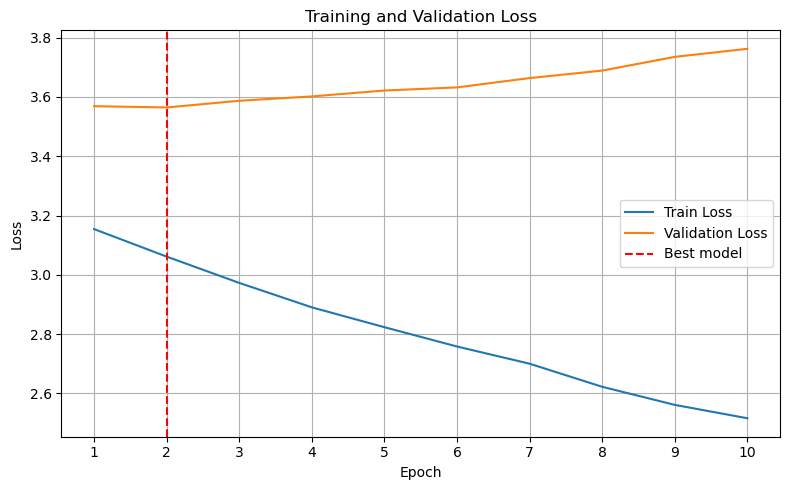

In [28]:
best_epoch = val_losses.index(min(val_losses))

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')

plt.axvline(x=best_epoch + 1, color='red', linestyle='--', label=f'Best model')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(np.arange(1, len(train_losses) + 1, 1)) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Examples:

In [29]:
def predict_top3(input_words):
    """
    Predict the top-3 most likely next words given an input sequence.

    Parameters:
    - input_words (list of str): A list of (n-1) words to use as context for prediction.
      The length must match the window size used during training.

    Behavior:
    - Converts input words to indices, replacing out-of-vocabulary words with <UNK> (index 0).
    - Feeds the input sequence to the model to obtain logits for all words in the vocabulary.
    - Masks the <UNK> token to prevent it from being selected.
    - Returns the top-3 most probable words as predicted by the model.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)

    expected_len = len(inputs_train[0])  # Expected input length (n-1 words)
    if len(input_words) != expected_len:
        print(f"You need to provide exactly {expected_len} words.")
        return

    # Map input words to indices, use 0 for unknown words
    idx_seq = [word2idx.get(w, 0) for w in input_words]

    # Convert to tensor and add batch dimension
    x = torch.tensor(idx_seq, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        logits = model(x).squeeze(0)  # Output shape: [vocab_size]

        # Prevent <UNK> from being predicted
        logits[0] = float('-inf')

        # Get top-3 word indices
        top3 = torch.topk(logits, 3).indices.tolist()

    # Print input and predictions
    print("Input:", ' '.join(input_words))
    print("Top-3 predictions:")
    for i, idx in enumerate(top3):
        word = idx2word.get(idx)
        print(f"{i+1}. {word}")


In [30]:
predict_top3(["he", "looked", "at", "the"])

Input: he looked at the
Top-3 predictions:
1. usurper
2. night
3. man


In [31]:
predict_top3(["tyrion", "knew", "what", "he"])

Input: tyrion knew what he
Top-3 predictions:
1. had
2. could
3. was


In [116]:
predict_top3(["i", "have", "no", "idea"])

Input: i have no idea
Top-3 predictions:
1. and
2. at
3. perhaps


In [132]:
predict_top3(["the", "fire", "burned", "through"])

Input: the fire burned through
Top-3 predictions:
1. the
2. her
3. his
